# Zero-shot prediction of BRCA1 variant effects with Evo 2
Deploy this tutorial on brev.dev: 
[![ Click here to deploy.](https://brev-assets.s3.us-west-1.amazonaws.com/nv-lb-dark.svg)](https://console.brev.dev/launchable/deploy?launchableID=env-2uGqxNLgVdl752F2qcTFwHHn4Rj)

*Note - this notebook is a reproduction of The Arc Institute’s same-titled notebook [here](https://github.com/ArcInstitute/evo2/blob/main/notebooks/brca1/brca1_zero_shot_vep.ipynb), using the BioNeMo 2 implementation of Evo2.*

Evo2 is a foundation AI model trained on 9.3 trillion DNA base pairs, predicting variant effects without prior tast-specific training. 

Without being explicitly trained on BRCA1 variants, we show Evo 2's ability to generalize across all life forms.

The human *BRCA1* gene encodes for a protein that repairs damaged DNA ([Moynahan et al., 1999](https://www.cell.com/molecular-cell/fulltext/S1097-2765%2800%2980202-6)). Certain variants of this gene have been associated with an increased risk of breast and ovarian cancers ([Miki et al., 1994](https://www.science.org/doi/10.1126/science.7545954?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed)). Using Evo 2, we can predict whether a particular single nucleotide variant (SNV) of the *BRCA1* gene is likely to be harmful to the protein's function, and thus potentially increase the risk of cancer for the patient with the genetic variant.

In [1]:
%%capture
!pip install biopython openpyxl
import os


# Runs a subset of the model layers to test that the notebook runs in CI, but the output will be incorrect.
FAST_CI_MODE: bool = bool(int(os.environ.get("FAST_CI_MODE", "0")))

In [2]:
import glob
import gzip
import json
import math
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from Bio import SeqIO
from sklearn.metrics import auc, roc_auc_score, roc_curve

from bionemo.core.utils.subprocess_utils import run_subprocess_safely

/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:65: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


We start by loading a dataset from [Findlay et al. (2018)](https://www.nature.com/articles/s41586-018-0461-z), which contains experimentally measured function scores of 3,893 *BRCA1* SNVs. These function scores reflect the extent by which the genetic variant has disrupted the protein's function, with lower scores indicating greater disruption. In this dataset, the SNVs are classified into three categories based on their function scores: `LOF` (loss-of-function), `INT` (intermediate), and `FUNC` (functional). We start by reading in this dataset.

To keep the notebook streamlined, we've abstracted much of the preprocessing logic into accompanying scripts located in `brca1_utils`. This notebook can also be viewed [here](https://docs.nvidia.com/bionemo-framework/latest/main/examples/bionemo-evo2/zeroshot_brca1/).

In [3]:
def download_data(data_dir="brca1", commit_hash="3819474bee6c24938016614411f1fa025e542bbe"):
    """Download required data files if they don't exist locally.

    Parameters:
    -----------
    data_dir : str
        Directory to store downloaded files
    commit_hash : str
        GitHub commit hash for data version
    """
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    excel_path = os.path.join(data_dir, "41586_2018_461_MOESM3_ESM.xlsx")
    genome_path = os.path.join(data_dir, "GRCh37.p13_chr17.fna.gz")

    if not os.path.exists(excel_path):
        os.system(
            f"wget https://github.com/ArcInstitute/evo2/raw/{commit_hash}/notebooks/brca1/41586_2018_461_MOESM3_ESM.xlsx -O {excel_path}"
        )

    if not os.path.exists(genome_path):
        os.system(
            f"wget https://github.com/ArcInstitute/evo2/raw/{commit_hash}/notebooks/brca1/GRCh37.p13_chr17.fna.gz -O {genome_path}"
        )

    return excel_path, genome_path


def load_genome_sequence(genome_path):
    """Load genome sequence from FASTA file.

    Parameters:
    -----------
    genome_path : str
        Path to the genome FASTA file

    Returns:
    --------
    str
        Genome sequence string
    """
    with gzip.open(genome_path, "rt") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            return str(record.seq)

    raise ValueError("Failed to parse genome sequence")


def load_brca1_data(excel_path):
    """Load and preprocess BRCA1 data from Excel file.

    Parameters:
    -----------
    excel_path : str
        Path to the Excel file

    Returns:
    --------
    pandas.DataFrame
        Processed BRCA1 dataframe
    """
    # Load the dataframe
    brca1_df = pd.read_excel(excel_path, header=2)

    # Select and rename columns
    brca1_df = brca1_df[
        [
            "chromosome",
            "position (hg19)",
            "reference",
            "alt",
            "function.score.mean",
            "func.class",
        ]
    ]

    brca1_df.rename(
        columns={
            "chromosome": "chrom",
            "position (hg19)": "pos",
            "reference": "ref",
            "alt": "alt",
            "function.score.mean": "score",
            "func.class": "class",
        },
        inplace=True,
    )

    # Convert to two-class system
    brca1_df["class"] = brca1_df["class"].replace(["FUNC", "INT"], "FUNC/INT")

    return brca1_df

In [4]:
%%capture

# Configuration parameters
DATA_DIR = "brca1"
SAMPLE_CONFIG = {"sample_frac": 0.1, "balanced": True, "disable": False, "random_state": 42}

# 1. Download the necessary data files if not present
excel_path, genome_path = download_data(DATA_DIR)
seq_chr17 = load_genome_sequence(genome_path)

# 2. Load and preprocess BRCA1 data
brca1_df = load_brca1_data(excel_path)

We then group the `FUNC` and `INT` classes of SNVs together into a single category (`FUNC/INT`).



We build a function to parse the reference and variant sequences of a 8,192-bp window around the genomic position of each SNV, using the reference sequence of human chromosome 17 where *BRCA1* is located.



To make things run faster, we'll just look at a balanced sample of our data. If you want to run on the full dataset, set `disable_sample=True`

In [5]:
def sample_data(df, sample_frac=1.0, balanced=True, disable=False, random_state=42):
    """Sample dataframe, optionally with balanced classes.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    sample_frac : float
        Fraction of data to sample
    balanced : bool
        Whether to balance classes
    disable : bool
        Whether to disable sampling
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    pandas.DataFrame
        Sampled dataframe
    """
    if disable:
        return df

    if balanced:
        # Get the number of rows in the dataframe
        num_rows_minor_class = math.ceil(len(df[df["class"] == "LOF"]) * sample_frac)
        return (
            pd.concat(
                [
                    df[df["class"] == "LOF"].sample(n=num_rows_minor_class, random_state=random_state),
                    df[df["class"] == "FUNC/INT"].sample(n=num_rows_minor_class, random_state=random_state),
                ]
            )
            .sample(frac=1.0, random_state=random_state)
            .reset_index(drop=True)
        )
    else:
        # Calculate the number of rows to sample
        return df.sample(frac=sample_frac, random_state=random_state).reset_index(drop=True)

In [6]:
OUTPUT_DIR = "brca1_fasta_files"

brca1_df = sample_data(
    brca1_df,
    sample_frac=SAMPLE_CONFIG["sample_frac"],
    balanced=SAMPLE_CONFIG["balanced"],
    disable=SAMPLE_CONFIG["disable"],
    random_state=SAMPLE_CONFIG["random_state"],
)

brca1_df.head(5)

,chrom,pos,ref,alt,score,class
0,17,41276097,A,G,0.326953,FUNC/INT
1,17,41201130,A,G,0.056569,FUNC/INT
2,17,41215938,T,A,-2.017579,LOF
3,17,41215932,A,C,-1.706222,LOF
4,17,41219685,G,T,0.037593,FUNC/INT


Next, we'll write these to local `.fasta` files so we can use them for prediction below.

In [7]:
def parse_sequences(pos, ref, alt, seq_chr17, window_size=8192):
    """Parse reference and variant sequences from the reference genome sequence.

    Parameters:
    -----------
    pos : int
        Position (1-indexed)
    ref : str
        Reference base
    alt : str
        Alternate base
    seq_chr17 : str
        Full chromosome 17 sequence
    window_size : int
        Size of the sequence window to extract

    Returns:
    --------
    tuple
        (reference_sequence, variant_sequence)
    """
    p = pos - 1  # Convert to 0-indexed position
    full_seq = seq_chr17

    ref_seq_start = max(0, p - window_size // 2)
    ref_seq_end = min(len(full_seq), p + window_size // 2)
    ref_seq = seq_chr17[ref_seq_start:ref_seq_end]
    snv_pos_in_ref = min(window_size // 2, p)
    var_seq = ref_seq[:snv_pos_in_ref] + alt + ref_seq[snv_pos_in_ref + 1 :]

    # Sanity checks
    assert len(var_seq) == len(ref_seq)
    assert ref_seq[snv_pos_in_ref] == ref
    assert var_seq[snv_pos_in_ref] == alt

    return ref_seq, var_seq


def generate_fasta_files(df, seq_chr17, output_dir="brca1_fasta_files", window_size=8192):
    """Generate FASTA files for reference and variant sequences.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe with variant information
    seq_chr17 : str
        Chromosome 17 sequence
    output_dir : str
        Output directory for FASTA files
    window_size : int
        Size of sequence window

    Returns:
    --------
    pandas.DataFrame
        Dataframe with added columns for FASTA names
    """
    # Create output directory
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Paths for output files
    ref_fasta_path = output_dir / "brca1_reference_sequences.fasta"
    var_fasta_path = output_dir / "brca1_variant_sequences.fasta"

    # Track unique sequences
    ref_sequences = set()
    var_sequences = set()
    ref_seq_to_name = {}

    # Store unique sequences with metadata for writing
    ref_entries = []
    var_entries = []
    ref_names = []
    var_names = []

    # Collect unique reference and variant sequences
    for idx, row in df.iterrows():
        ref_seq, var_seq = parse_sequences(row["pos"], row["ref"], row["alt"], seq_chr17, window_size)

        # Add to sets to ensure uniqueness
        if ref_seq not in ref_sequences:
            ref_sequences.add(ref_seq)
            ref_name = f"BRCA1_ref_pos_{row['pos']}_{row['ref']}_class_{row['class']}"

            ref_entries.append(f">{ref_name}\n{ref_seq}\n")
            ref_names.append(ref_name)
            ref_seq_to_name[ref_seq] = ref_name
        else:
            ref_name = ref_seq_to_name[ref_seq]
            ref_names.append(ref_name)

        if var_seq not in var_sequences:
            var_sequences.add(var_seq)
            var_name = f"BRCA1_var_pos_{row['pos']}_{row['ref']}to{row['alt']}_class_{row['class']}"

            var_entries.append(f">{var_name}\n{var_seq}\n")
            var_names.append(var_name)
        else:
            assert False, "Duplicate variant sequence"

    # Write unique sequences to FASTA files
    with open(ref_fasta_path, "w") as f:
        f.writelines(ref_entries)

    with open(var_fasta_path, "w") as f:
        f.writelines(var_entries)

    # Add FASTA names to dataframe
    df_with_names = df.copy()
    df_with_names["ref_fasta_name"] = ref_names
    df_with_names["var_fasta_name"] = var_names

    print(f"Total unique reference sequences: {len(ref_sequences)}")
    print(f"Total unique variant sequences: {len(var_sequences)}")

    return df_with_names

In [8]:
brca1_df = generate_fasta_files(brca1_df, seq_chr17, output_dir=OUTPUT_DIR)

Total unique reference sequences: 156
Total unique variant sequences: 166


### Load Evo 2 Checkpoints


Then, we load Evo 2 1B model, loading the Evo 2 weights from hugging face.

*Note - for better performance, load the 7b model by setting `MODEL_SIZE="7b"` which also works well GPUs that do not support FP8.*



In [9]:
%%capture
MODEL_SIZE = "1b"  # also try 7b if you have a GPU with more than 32GB of memory

# Define checkpoint path
if MODEL_SIZE == "1b":
    from pathlib import Path

    from bionemo.core.data.load import load

    #  This line will download the checkpoint from NGC to your $HOME/.cache/bionemo directory and return the path.
    #  To do the same from the command line, use `CHECKPOINT_PATH=$(download_bionemo_data evo2/1b-8k-bf16:1.0)`

    # Download the 1b BF16 checkpoint from NGC
    # Available checkpoints: evo2/1b-8k-bf16:1.0, evo2/1b-8k:1.0, evo2/7b-8k:1.0, evo2/7b-1m:1.0
    nemo2_ckpt_path = load("evo2/1b-8k-bf16:1.0")
    checkpoint_path = Path("evo2_1b_bf16_mbridge")
    from bionemo.evo2.data.dataset_tokenizer import (
        DEFAULT_HF_TOKENIZER_MODEL_PATH_512,  # use the 512 size for historical reasons
    )

    mixed_precision_recipe = "bf16_mixed"  # also try bf16_with_fp8_current_scaling_mixed
    convert_ckpt_cmd = f"""evo2_convert_nemo2_to_mbridge \
        --nemo2-ckpt-dir {nemo2_ckpt_path} \
        --mbridge-ckpt-dir {checkpoint_path} \
        --model-size 1b \
        --mixed-precision-recipe {mixed_precision_recipe} \
        --seq-length 8192 \
        --tokenizer-path {DEFAULT_HF_TOKENIZER_MODEL_PATH_512} \
    """.rstrip()
    print(f"Running command: {convert_ckpt_cmd}")

    result = run_subprocess_safely(convert_ckpt_cmd)
    print(f"Downloaded checkpoint to: {nemo2_ckpt_path} and converted to mbridge format at {checkpoint_path}")
else:
    assert False, "Implement conversion for other model sizes. Should be similar to the 1b case above."

### Score Sequences

Next, we score the likelihoods of the reference and variant sequences of each SNV.


In [10]:
def check_fp8_support():
    """Check if FP8 is supported on the current GPU.

    FP8 requires compute capability 8.9+ (Ada Lovelace/Hopper architecture or newer).
    """
    if not torch.cuda.is_available():
        return False, "CUDA not available"

    device_props = torch.cuda.get_device_properties(0)
    compute_capability = f"{device_props.major}.{device_props.minor}"
    device_name = device_props.name

    # FP8 is supported on compute capability 8.9+ (Ada Lovelace/Hopper architecture)
    is_supported = (device_props.major > 8) or (device_props.major == 8 and device_props.minor >= 9)

    return is_supported, f"Device: {device_name}, Compute Capability: {compute_capability}"

In [11]:
# Define output directories for prediction results
output_dir = Path("brca1_fasta_files")
output_dir.mkdir(parents=True, exist_ok=True)

# Save reference and variant sequences to FASTA
ref_fasta_path = output_dir / "brca1_reference_sequences.fasta"
var_fasta_path = output_dir / "brca1_variant_sequences.fasta"

predict_ref_dir = output_dir / "reference_predictions"
predict_var_dir = output_dir / "variant_predictions"
predict_ref_dir.mkdir(parents=True, exist_ok=True)
predict_var_dir.mkdir(parents=True, exist_ok=True)

fp8_supported, gpu_info = check_fp8_support()
print(f"FP8 Support: {fp8_supported}")
print(gpu_info)

# Note: If FP8 is not supported, you may want to disable it in the model config
# The Evo2 config has 'use_fp8_input_projections: True' by default

if FAST_CI_MODE:
    model_subset_option = "--num-layers 4 --hybrid-override-pattern SDH*"
else:
    model_subset_option = ""

# Disable FP8 for now, it is underperforming at the moment in prediction. 0.7 vs 0.76 and similar run times.
fp8_option = "--mixed-precision-recipe bf16_with_fp8_current_scaling_mixed" if fp8_supported else ""

# Update predict commands to run on the full dataset
predict_ref_command = (
    f"predict_evo2 --fasta {ref_fasta_path} --ckpt-dir {checkpoint_path} "
    f"--output-dir {predict_ref_dir} --tensor-parallel-size 1  {model_subset_option} "
    f"--pipeline-model-parallel-size 1 --context-parallel-size 1 --output-log-prob-seqs {fp8_option}"
)

predict_var_command = (
    f"predict_evo2 --fasta {var_fasta_path} --ckpt-dir {checkpoint_path} "
    f"--output-dir {predict_var_dir} --tensor-parallel-size 1 {model_subset_option} "
    f"--pipeline-model-parallel-size 1 --context-parallel-size 1 --output-log-prob-seqs {fp8_option}"
)

FP8 Support: True
Device: NVIDIA GeForce RTX 5090, Compute Capability: 12.0


Score reference sequences:

In [12]:
%%capture
print(f"Running command: {predict_ref_command}")

result = run_subprocess_safely(predict_ref_command)

In [13]:
assert result["returncode"] == 0, result

Score variant sequences:

In [14]:
%%capture
print(f"Running command: {predict_var_command}")

result = run_subprocess_safely(predict_var_command)

In [15]:
assert result["returncode"] == 0, result

We calculate the change in likelihoods for each variant relative to the likelihood of their respective wild-type sequence.



First, we load the prediction files and sequence id maps:

In [16]:
# Find and load prediction files
# File naming convention (epoch mode): predictions__rank_{global_rank}__dp_rank_{dp_rank}.pt
ref_pred_files = glob.glob(os.path.join(predict_ref_dir, "predictions__rank_*.pt"))
var_pred_files = glob.glob(os.path.join(predict_var_dir, "predictions__rank_*.pt"))

# Load sequence ID maps (maps sequence ID -> prediction index)
with open(os.path.join(predict_ref_dir, "seq_idx_map.json"), "r") as f:
    ref_seq_idx_map = json.load(f)
with open(os.path.join(predict_var_dir, "seq_idx_map.json"), "r") as f:
    var_seq_idx_map = json.load(f)

# Load predictions
ref_preds = torch.load(ref_pred_files[0])
var_preds = torch.load(var_pred_files[0])

Then, calculate the delta score:

In [17]:
# next, calculate change in likelihoods
ref_log_probs = []
var_log_probs = []
for _, row in brca1_df.iterrows():
    ref_name = row["ref_fasta_name"]
    var_name = row["var_fasta_name"]
    ref_log_probs.append(ref_preds["log_probs_seqs"][ref_seq_idx_map[ref_name]].item())
    var_log_probs.append(var_preds["log_probs_seqs"][var_seq_idx_map[var_name]].item())
brca1_df["ref_log_probs"] = ref_log_probs
brca1_df["var_log_probs"] = var_log_probs
# ideally probability of a broken variant is lower than a good one. So a bad var - good ref is negative.
brca1_df["evo2_delta_score"] = brca1_df["var_log_probs"] - brca1_df["ref_log_probs"]
brca1_df.head()

,chrom,pos,ref,alt,score,class,ref_fasta_name,var_fasta_name,ref_log_probs,var_log_probs,evo2_delta_score
0,17,41276097,A,G,0.326953,FUNC/INT,BRCA1_ref_pos_41276097_A_class_FUNC/INT,BRCA1_var_pos_41276097_AtoG_class_FUNC/INT,-0.935537,-0.935760,-0.000223
1,17,41201130,A,G,0.056569,FUNC/INT,BRCA1_ref_pos_41201130_A_class_FUNC/INT,BRCA1_var_pos_41201130_AtoG_class_FUNC/INT,-0.929413,-0.929956,-0.000543
2,17,41215938,T,A,-2.017579,LOF,BRCA1_ref_pos_41215938_T_class_LOF,BRCA1_var_pos_41215938_TtoA_class_LOF,-0.864209,-0.866731,-0.002521
3,17,41215932,A,C,-1.706222,LOF,BRCA1_ref_pos_41215932_A_class_LOF,BRCA1_var_pos_41215932_AtoC_class_LOF,-0.864879,-0.866319,-0.001440
4,17,41219685,G,T,0.037593,FUNC/INT,BRCA1_ref_pos_41219685_G_class_FUNC/INT,BRCA1_var_pos_41219685_GtoT_class_FUNC/INT,-1.027526,-1.027546,-0.000020


This delta likelihood should be predictive of how disruptive the SNV is to the protein's function: the lower the delta, the more likely that the SNV is disruptive. We can show this by comparing the distributions of delta likelihoods for the two classes of SNVs (functional/intermediate vs loss-of-function).

In [18]:
def plot_strip_with_means(df, x_col="evo2_delta_score", class_col="class"):
    """Creates a strip plot with jittered points and median indicators for each class using Seaborn.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing data.
    - x_col (str): The column name representing the x-axis values (e.g., evo2_delta_score).
    - class_col (str): The column name representing the class labels.

    Returns:
    - matplotlib Figure: Strip plot with median indicators.
    """
    # NVIDIA theme colors
    NVIDIA_GREEN = "#76B900"  # noqa: N806
    BACKGROUND_COLOR = "#F8F8F8"  # noqa: N806
    GRID_COLOR = "#DDDDDD"  # noqa: N806
    FONT_COLOR = "#333333"  # noqa: N806

    # Determine order of classes (if not already specified)
    unique_classes = sorted(df[class_col].unique())

    # Set up the plot with NVIDIA theme
    plt.figure(figsize=(9, 5), facecolor=BACKGROUND_COLOR)
    plt.style.use("default")  # Reset to default to avoid any pre-existing style

    # Create strip plot
    p = sns.stripplot(
        data=df,
        x=x_col,
        y=class_col,
        hue=class_col,
        order=unique_classes,
        palette=[NVIDIA_GREEN, "red"],
        size=6,
        jitter=0.3,
        alpha=0.6,
    )

    # Add median indicators using boxplot
    sns.boxplot(
        showmeans=True,
        meanline=True,
        meanprops={"visible": False},
        medianprops={"color": "black", "ls": "-", "lw": 2},
        whiskerprops={"visible": False},
        zorder=10,
        x=x_col,
        y=class_col,
        data=df,
        order=unique_classes,
        showfliers=False,
        showbox=False,
        showcaps=False,
        ax=p,
    )

    # Customize plot appearance
    plt.title(
        "Distribution of Delta Likelihoods Scores\nComparing Evo 2 likelihood scores for different BRCA1 SNV classes",
        color=FONT_COLOR,
        fontsize=12,
        loc="left",
    )
    plt.xlabel("Delta Likelihood Score, Evo 2", color=FONT_COLOR)
    plt.ylabel("BRCA1 SNV Class", color=FONT_COLOR)

    # Customize grid and tick colors
    plt.grid(color=GRID_COLOR, axis="x", linestyle="--", linewidth=0.5)
    plt.tick_params(colors=FONT_COLOR)

    # Set background color
    plt.gca().set_facecolor(BACKGROUND_COLOR)
    plt.gcf().set_facecolor(BACKGROUND_COLOR)

    plt.tight_layout()

    # return plt.gcf()

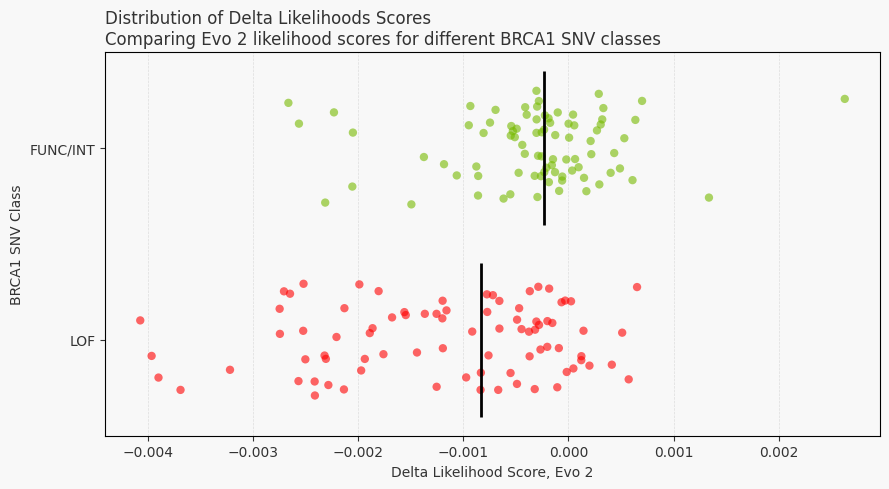

In [19]:
plot_strip_with_means(brca1_df, x_col="evo2_delta_score", class_col="class")

We can also calculate the area under the receiver operating characteristic curve (AUROC) of this zero-shot prediction method. Note that the results are nearly random unless you are on one of the following configurations:
* `--fp8` on an fp8 enabled GPU with either the 1b or 7b models. The 40b likely works as well.
* the 7b model uniquely seems to work well without `--fp8` so if you are on an older device, the 7b model should produce
  robust results. Change the `MODEL_SIZE` earlier in this tutorial and rerun for good results in that case.



In [20]:
# Calculate AUROC of zero-shot predictions
#  class 1 is LOF which is the bad thing. That means we expect this to be more negative.
y_true = brca1_df["class"] == "LOF"
auroc = roc_auc_score(y_true, -brca1_df["evo2_delta_score"])
print(f"Zero-shot prediction AUROC: {auroc:.2}")

Zero-shot prediction AUROC: 0.73


In [21]:
def plot_roc_curve(df):
    """Plots an ROC curve using Seaborn with a light NVIDIA-themed design.

    The function assumes:
    - `class` column as the true labels (binary, 'LOF' = 1, else 0).
    - `evo2_delta_score` as the prediction score.

    Parameters:
    - df (pd.DataFrame): DataFrame containing `class` and `evo2_delta_score`.

    Returns:
    - matplotlib Figure: ROC Curve Visualization.
    """
    # NVIDIA theme colors
    NVIDIA_GREEN = "#76B900"  # noqa: N806
    BACKGROUND_COLOR = "#F8F8F8"  # noqa: N806
    GRID_COLOR = "#DDDDDD"  # noqa: N806
    FONT_COLOR = "#333333"  # noqa: N806

    # Validate required columns
    if "class" not in df.columns or "evo2_delta_score" not in df.columns:
        raise ValueError("DataFrame must contain 'class' and 'evo2_delta_score' columns.")

    # Convert 'class' to binary labels: Assume 'LOF' = 1, anything else = 0
    y_true = (df["class"] == "LOF").astype(int)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, -df["evo2_delta_score"])  # Negative to align with previous logic
    roc_auc = auc(fpr, tpr)

    # Set up the plot with NVIDIA theme
    plt.figure(figsize=(9, 5), facecolor=BACKGROUND_COLOR)
    plt.style.use("default")  # Reset to default to avoid any pre-existing style

    # Plot ROC curve
    plt.plot(fpr, tpr, color=NVIDIA_GREEN, lw=3, label=f"ROC curve (AUROC = {roc_auc:.2f})")

    # Plot diagonal reference line for random guessing
    plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")

    # Customize plot appearance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", color=FONT_COLOR, fontsize=12)
    plt.ylabel("True Positive Rate", color=FONT_COLOR, fontsize=12)
    plt.title(
        "Zeroshot ROC Curve\nEvaluating the discriminative performance of Evo 2 predictions",
        color=FONT_COLOR,
        fontsize=16,
        loc="left",
    )

    # Customize grid and tick colors
    plt.grid(color=GRID_COLOR, linestyle="--", linewidth=0.5)
    plt.tick_params(colors=FONT_COLOR)

    # Set background color
    plt.gca().set_facecolor(BACKGROUND_COLOR)

    # Add legend
    plt.legend(loc="lower right", frameon=True, facecolor=BACKGROUND_COLOR, edgecolor=GRID_COLOR)

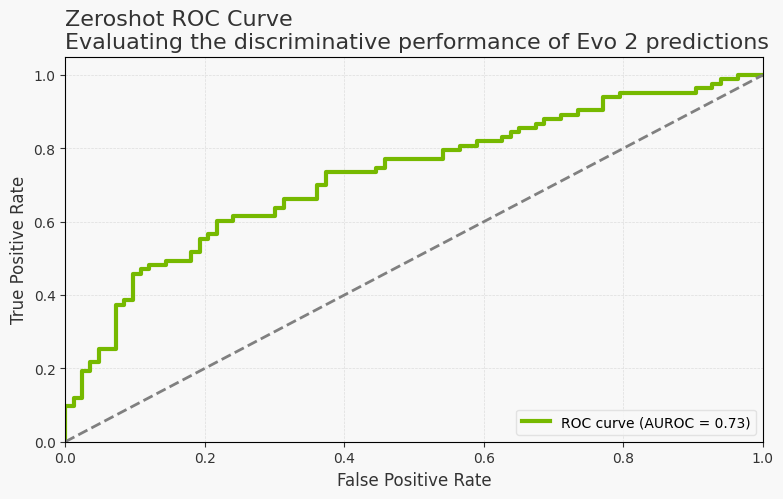

In [22]:
plot_roc_curve(brca1_df)

In [23]:
# Check if the AUC is a reasonable value for our CI suite when we run the full model
assert FAST_CI_MODE or auroc >= 0.7

### Full Sample Performance

The above analysis may have been performed on a subset of the available data.

For comparison, the table below presents the AUROC scores for different model sizes trained on the *full dataset* (100% sample fraction).

| Model Size  | Dataset Sample Fraction | AUROC |
|------------|------------------------|-------|
| Evo 2 1B   | 100%                   | 0.74  |
| Evo 2 7B   | 100%                   | 0.87  |
